# Study 3 – Dataset characterisation and signal quality analysis

This notebook implements Study 3 of the thesis, focusing on:
- Global characterisation of the ePatch ECG dataset
- Seizure distribution and inter-seizure intervals
- Segment-level labelling (seizure vs. baseline) using fixed 60 s windows
- Signal quality and noise characteristics using SQI and spectral metrics
- Peri-ictal windows around seizures (legacy window scheme)
- Illustrative case studies and visualisations


## Imports

In [1]:
from pathlib import Path
from dataclasses import asdict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project style
from src.hrv_epatch.plots.plotstyle import set_project_style
set_project_style()  # ensartet grøn stil på alle plots

# Dataset-API
from src.hrv_epatch.dataset.index import build_recording_index
from src.hrv_epatch.dataset.loader import iter_recordings
from src.hrv_epatch.dataset.seizures import build_seizure_events_from_df, SeizureEvent
from src.hrv_epatch.dataset.summary import (
    compute_dataset_overview,
    build_patient_summary,
    compute_within_recording_isi,
    summarise_isi,
)
from src.hrv_epatch.dataset.segments import build_segment_index

# IO / TDMS
from src.hrv_epatch.io.tdms import load_tdms_from_path, TdmsMeta

# SQI og noise metrics
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    SQIThresholds,
    compute_sqi_for_many_segments,
    classify_many_segments,
)
from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

# Frequenzy / PSD
from src.hrv_epatch.features.frequency import (
    compute_psd,
    summarize_psd_bands,
    plot_psd,
)

# Seizure-windows (peri-ictal)
from src.hrv_epatch.seizure.windows import analyze_shifted_windows

# Plots
from src.hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from src.hrv_epatch.plots.rpeak import plot_raw_vs_clean_with_peaks

# Eventually: Jeppesen/HRV-pipeline if needed
# from src.hrv_epatch.rpeak.jeppesen_pipeline import run_pipeline_from_ecg

from src.hrv_epatch.dataset.dataset_builders import build_df_rec_and_df_evt

plt.close("all")
pd.options.display.max_columns = 50


## Configuration

In [2]:
# >>> Tilpas disse til din lokale struktur <<<
BASE_DIR = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne")
TDMS_ROOT = BASE_DIR / "Patients ePatch data"
ANN_ROOT = BASE_DIR / "Seizure log ePatch patients with seizures - excluded seizures removed"

OUT_DIR = Path(r"E:\Speciale - Results") / "_analysis" / "study3"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Segment- og vinduesparametre
SEGMENT_LEN_S = 60.0  # faste 60 s segmenter til global karakterisering
PERIICTAL_OFFSETS_MIN = [-20, -2, 0, 2, 20]  # eksempel-værdier, kan tweakes
PERIICTAL_WINDOW_LEN_S = 60.0  # længde af hver peri-ictal vindue
FS_FALLBACK = 512.0


## 1. Build recording index

We first construct a structured index of all TDMS recordings and their corresponding
annotation files using the `hrv_epatch.dataset.index` module.

In [3]:
recording_index = build_recording_index(TDMS_ROOT, ANN_ROOT)
recording_index[:5]

[RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=1), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 1/Patient 1_1.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=2), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 2/Patient 1_2.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=2, enrollment_id=None, recording_id=1), tdms_path=WindowsPath(

In [4]:
entries = build_recording_index(TDMS_ROOT, ANN_ROOT)

print("Antal entries:", len(entries))
for e in entries[:10]:
    print(
        "UID:",
        f"P{e.key.patient_id:02d}{e.key.enrollment_id or ''}_R{e.key.recording_id:02d}",
        "| TDMS:", e.tdms_path.name,
        "| ANN:", e.annotation_path.name if e.annotation_path is not None else None,
    )


Antal entries: 72
UID: P01_R01 | TDMS: Patient 1_1.tdms | ANN: patient 1.xls
UID: P01_R02 | TDMS: Patient 1_2.tdms | ANN: patient 1.xls
UID: P02_R01 | TDMS: Patient 2_1.tdms | ANN: patient 2.xls
UID: P03_R01 | TDMS: Patient 3_1.tdms | ANN: patient 3.xls
UID: P03_R02 | TDMS: Patient 3_2.tdms | ANN: patient 3.xls
UID: P04_R01 | TDMS: Patient 4_1.tdms | ANN: patient 4.xls
UID: P05_R01 | TDMS: Patient 5_1.tdms | ANN: patient 5.xls
UID: P06_R01 | TDMS: Patient 6_1.tdms | ANN: patient 6.xls
UID: P06_R02 | TDMS: Patient 6_2.tdms | ANN: patient 6.xls
UID: P07_R01 | TDMS: Patient 7_1.tdms | ANN: patient 7.xls


## 2. Build recording- and event-level tables

We iterate over all recordings and build:
- `df_rec`: one row per recording (duration, patient/enrollment, etc.)
- `df_evt`: one row per seizure event (absolute start/stop, recording ID, etc.)

In [5]:
df_rec, df_evt = build_df_rec_and_df_evt(TDMS_ROOT, ANN_ROOT)
print(len(df_rec), "recordings")
print(len(df_evt), "seizure events")
df_evt.head()


[INFO] P01_R01: 1 seizures
[INFO] P01_R02: 2 seizures
[INFO] P02_R01: 9 seizures
[INFO] P03_R01: 2 seizures
[INFO] P03_R02: 1 seizures
[INFO] P04_R01: 1 seizures
[INFO] P05_R01: 3 seizures
[INFO] P06_R01: 1 seizures
[INFO] P06_R02: 0 seizures
[INFO] P07_R01: 3 seizures
[INFO] P07_R02: 1 seizures
[INFO] P08a_R01: 1 seizures
[INFO] P08a_R02: 0 seizures
[INFO] P08b_R01: 1 seizures
[INFO] P09_R01: 3 seizures
[INFO] P09_R02: 0 seizures
[INFO] P10_R01: 1 seizures
[INFO] P11_R01: 2 seizures
[INFO] P11_R02: 4 seizures
[INFO] P12_R01: 2 seizures
[INFO] P12_R02: 1 seizures
[INFO] P13_R01: 1 seizures
[INFO] P13_R02: 7 seizures
[INFO] P14_R01: 0 seizures
[INFO] P14_R02: 7 seizures
[INFO] P15_R01: 0 seizures
[INFO] P15_R02: 1 seizures
[INFO] P16_R01: 1 seizures
[INFO] P17_R01: 1 seizures
[INFO] P18_R01: 3 seizures
[INFO] P19_R01: 3 seizures
[INFO] P20_R01: 4 seizures
[INFO] P20_R02: 2 seizures
[INFO] P21_R01: 1 seizures
[INFO] P21_R02: 0 seizures
[INFO] P22_R01: 0 seizures
[INFO] P22_R02: 5 seizure

,recording_uid,patient_id,enrollment_id,recording_id,seizure_id,t0_s,t1_s,absolute_start,absolute_end
0,P01_R01,1,None,1,1,130187.0,130228.0,2016-02-23 23:14:01,2016-02-23 23:14:42
1,P01_R02,1,None,2,2,47163.0,47185.0,2016-02-25 05:21:03,2016-02-25 05:21:25
2,P01_R02,1,None,2,3,134180.0,134210.0,2016-02-26 05:31:20,2016-02-26 05:31:50
3,P02_R01,2,None,1,1,3209.0,3244.0,2016-05-03 14:12:34,2016-05-03 14:13:09
4,P02_R01,2,None,1,2,5841.0,5878.0,2016-05-03 14:56:26,2016-05-03 14:57:03


In [6]:
df_rec[["recording_uid", "patient_id", "recording_start", "recording_end", "rec_duration_s"]].head()


,recording_uid,patient_id,recording_start,recording_end,rec_duration_s
0,P01_R01,1,2016-02-22 11:04:14,2016-02-24 16:09:49.750000,191135.750000
1,P01_R02,1,2016-02-24 16:15:00,2016-02-26 09:00:00.001953,146700.001953
2,P02_R01,2,2016-05-03 13:19:05,2016-05-04 07:03:49.750000,63884.750000
3,P03_R01,3,2016-09-05 11:19:32,2016-09-07 10:49:54.500000,171022.500000
4,P03_R02,3,2016-09-07 10:50:46,2016-09-09 09:44:08.000000,168802.000000


## 3. Dataset overview

We summarise the dataset at recording- and patient level using helper functions:
- total number of patients, enrollments, recordings, seizures, and hours
- per-patient recording hours and seizure counts

In [7]:
overview = compute_dataset_overview(df_rec, df_evt)
display(overview)

patient_summary = build_patient_summary(df_rec, df_evt)
patient_summary.head()


,Metric,Value
0,Patients,43.000000
1,Enrollments,50.000000
2,Recordings,72.000000
3,Total hours,3264.034933
4,Total seizures,149.000000
5,Median rec. duration (h),45.550694
6,IQR rec. duration (h),9.043108


,Patient,Enrollment,Recordings,Total_hours,Total_seizures,Hours_per_seizure
0,1,-,2,93.843264,3.0,31.281088
1,2,-,1,17.745764,9.0,1.971752
2,3,-,2,94.395694,3.0,31.465231
3,4,-,1,15.812501,1.0,15.812501
4,5,-,1,44.737569,3.0,14.912523


## 4. Within-recording inter-seizure intervals (ISI)

We compute within-recording ISI distributions and summarise them numerically
and graphically.

In [11]:
isi = compute_within_recording_isi(df_evt)
isi_summary = summarise_isi(isi)

print("Number of ISI intervals:", len(isi))
display(isi_summary)


Number of ISI intervals: 92


,Metric,Value
0,n_intervals,92.000000
1,mean (s),18327.054348
2,median (s),6808.500000
3,IQR (s),14453.000000
4,min (s),206.000000
5,max (s),108365.000000


## 5. Segment index with fixed 60 s windows

We now discretise each recording into non-overlapping 60 s segments and
label each segment as `seizure` or `baseline` depending on overlap with any seizure.
This forms the basis for segment-level statistics and SQI.


In [13]:
segment_index = build_segment_index(df_rec, df_evt, window_s=SEGMENT_LEN_S)
segment_index.head()


,segment_id,patient_id,enrollment_id,recording_uid,segment_start,segment_end,label
0,0,1,None,P01_R01,2016-02-22 11:04:14,2016-02-22 11:05:14,baseline
1,1,1,None,P01_R01,2016-02-22 11:05:14,2016-02-22 11:06:14,baseline
2,2,1,None,P01_R01,2016-02-22 11:06:14,2016-02-22 11:07:14,baseline
3,3,1,None,P01_R01,2016-02-22 11:07:14,2016-02-22 11:08:14,baseline
4,4,1,None,P01_R01,2016-02-22 11:08:14,2016-02-22 11:09:14,baseline


In [14]:

segment_counts = (
    segment_index
    .groupby(["label"])
    .size()
    .rename("n_segments")
    .reset_index()
)
segment_counts


,label,n_segments
0,baseline,195490
1,seizure,316


In [15]:
seg_per_patient = (
    segment_index
    .groupby(["patient_id", "label"])
    .size()
    .unstack("label", fill_value=0)
)
seg_per_patient.head()


label,baseline,seizure
patient_id,,
1,5626,4
2,1051,13
3,5660,3
4,947,1
5,2677,7


### 6 Global distribution of 60 s segments

We first quantify how many fixed-length 60 s segments fall into each label
category (e.g. `baseline` vs. `seizure`) across the entire dataset.
This gives a sense of the class imbalance for subsequent analyses.


In [16]:
# Segments pr label (globalt)
seg_counts = (
    segment_index
    .groupby("label")
    .size()
    .rename("n_segments")
    .reset_index()
)

# Percentage
total_segments = seg_counts["n_segments"].sum()
seg_counts["fraction"] = seg_counts["n_segments"] / total_segments
seg_counts["percent"] = 100 * seg_counts["fraction"]

seg_counts


,label,n_segments,fraction,percent
0,baseline,195490,0.998386,99.838616
1,seizure,316,0.001614,0.161384


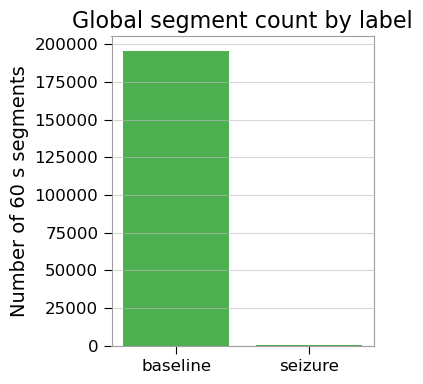

In [17]:
plt.figure(figsize=(4, 4))
plt.bar(seg_counts["label"], seg_counts["n_segments"])
plt.ylabel("Number of 60 s segments")
plt.title("Global segment count by label")
plt.tight_layout()
plt.show()


### 6.1 Segment distribution per patient

Next, we summarise the number of 60 s segments per label at patient level,
and convert these counts into hours of data per label.
This highlights between-patient differences in total monitored time and
seizure burden.

In [18]:
SEGMENT_LEN_S = 60.0  # samme som da vi byggede segment_index

# Antal segmenter pr. patient og label
seg_per_patient = (
    segment_index
    .groupby(["patient_id", "label"])
    .size()
    .rename("n_segments")
    .reset_index()
)

# Tilføj varighed (sekunder og timer)
seg_per_patient["duration_s"] = seg_per_patient["n_segments"] * SEGMENT_LEN_S
seg_per_patient["duration_h"] = seg_per_patient["duration_s"] / 3600.0

seg_per_patient.head()


,patient_id,label,n_segments,duration_s,duration_h
0,1,baseline,5626,337560.0,93.766667
1,1,seizure,4,240.0,0.066667
2,2,baseline,1051,63060.0,17.516667
3,2,seizure,13,780.0,0.216667
4,3,baseline,5660,339600.0,94.333333


In [19]:
# Pivot: én række pr. patient, kolonner for hver label (antal segmenter)
seg_counts_wide = (
    seg_per_patient
    .pivot(index="patient_id", columns="label", values="n_segments")
    .fillna(0)
    .astype(int)
)

# Tilsvarende i timer
seg_hours_wide = (
    seg_per_patient
    .pivot(index="patient_id", columns="label", values="duration_h")
    .fillna(0.0)
)

display(seg_counts_wide.head())
display(seg_hours_wide.head())


label,baseline,seizure
patient_id,,
1,5626,4
2,1051,13
3,5660,3
4,947,1
5,2677,7


label,baseline,seizure
patient_id,,
1,93.766667,0.066667
2,17.516667,0.216667
3,94.333333,0.050000
4,15.783333,0.016667
5,44.616667,0.116667


In [20]:
# Summarise pr. patient: total recording time og seizures-baseline balance
patient_seg_summary = seg_hours_wide.copy()
patient_seg_summary["total_hours"] = patient_seg_summary.sum(axis=1)

# Andel af tid i seizure-vinduer, hvis kolonnen findes
if "seizure" in patient_seg_summary.columns:
    patient_seg_summary["seizure_frac"] = (
        patient_seg_summary["seizure"] / patient_seg_summary["total_hours"]
    )
else:
    patient_seg_summary["seizure_frac"] = 0.0

patient_seg_summary.head()


label,baseline,seizure,total_hours,seizure_frac
patient_id,,,,
1,93.766667,0.066667,93.833333,0.000710
2,17.516667,0.216667,17.733333,0.012218
3,94.333333,0.050000,94.383333,0.000530
4,15.783333,0.016667,15.800000,0.001055
5,44.616667,0.116667,44.733333,0.002608


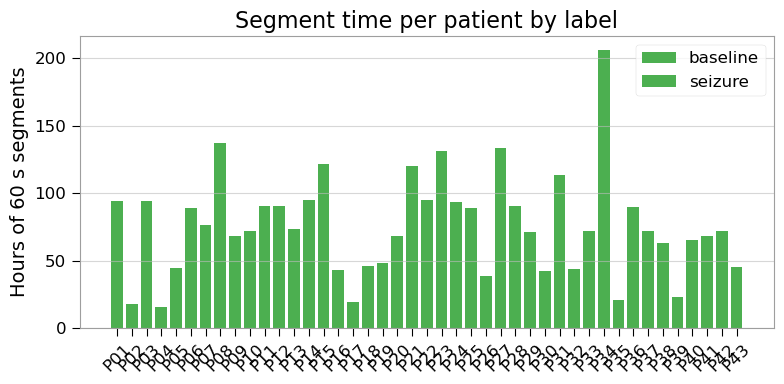

In [21]:
labels = seg_hours_wide.columns.tolist()

plt.figure(figsize=(8, 4))

bottom = np.zeros(len(seg_hours_wide))
x = np.arange(len(seg_hours_wide.index))

for lbl in labels:
    vals = seg_hours_wide[lbl].to_numpy()
    plt.bar(x, vals, bottom=bottom, label=lbl)
    bottom += vals

plt.xticks(x, [f"P{pid:02d}" for pid in seg_hours_wide.index], rotation=45)
plt.ylabel("Hours of 60 s segments")
plt.title("Segment time per patient by label")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def extract_segment_signal(sig, meta, seg_row):
    """Return raw ECG segment for a given segment row."""
    # antag seg_row har absolute_start / end som datetime
    t0 = seg_row["segment_start"]
    t1 = seg_row["segment_end"]
    i0 = int(((t0 - meta.start_time).total_seconds()) * meta.fs)
    i1 = int(((t1 - meta.start_time).total_seconds()) * meta.fs)
    return sig[i0:i1]


In [ ]:
# Placeholder-struktur: vi samler features og segment_id
sqi_feature_rows = []

# TODO: Optimér – her kan du nøjes med at køre per recording og mappe til segment_index.
# Skeleton:
sqi_cfg = SQIConfig()  # brug default eller tilpas
# thresholds = SQIThresholds(...)  # enten hårdkodet eller estimeret separat

# EKSEMPEL: Kun en lille subset først
for ridx, rec in df_rec.head(3).iterrows():
    sig, meta = load_tdms_from_path(rec["tdms_path"], channel_hint="EKG")
    seg_here = segment_index[segment_index["recording_uid"] == rec["recording_uid"]]

    for _, srow in seg_here.iterrows():
        x = extract_segment_signal(sig, meta, srow)
        # compute_sqi_features_for_segment bruges inde i compute_sqi_for_many_segments,
        # så her kan du enten kalde den direkte eller samle data til batch-kald.
        # sqi_feats = compute_sqi_features_for_segment(x, fs=meta.fs, cfg=sqi_cfg)
        # sqi_feature_rows.append({**sqi_feats, "segment_id": srow["segment_id"]})
        pass

# Når du vil køre rigtigt:
# df_sqi = pd.DataFrame(sqi_feature_rows)
# df_sqi = classify_many_segments(df_sqi, thresholds)


## 8. Noise and spectral characteristics

We complement the SQI analysis with PSD-based noise metrics and bandpower
profiles for selected segments / patients.

In [ ]:
example_seg = segment_index.iloc[0]
rec = df_rec[df_rec["recording_uid"] == example_seg["recording_uid"]].iloc[0]

sig, meta = load_tdms_from_path(rec["tdms_path"], channel_hint="EKG")
x_seg = extract_segment_signal(sig, meta, example_seg)

nm = noise_metrics(x_seg, fs=meta.fs)
print(nm)

f, Pxx = compute_psd(x_seg, fs=meta.fs)
bands = summarize_psd_bands(f, Pxx)
display(bands)

plot_psd(x_seg, fs=meta.fs, fmax=100.0)
plt.tight_layout()
plt.show()


## 9. Peri-ictal windows around seizures

In addition to the global 60 s segmentation, we construct peri-ictal windows
around each seizure to study how signal characteristics change before, during,
and after clinical events.

We reuse the previous scheme:
- seizure-only windows (matching seizure duration)
- seizure ±2 minutes
- “clean” baseline windows ~20 minutes before seizure

In [ ]:
# Eksempel: analyser peri-ictal vinduer for et subset af seizures
# analyze_shifted_windows kan tage en liste af offsets (i sek/min) og vindueslængde.
# Du tilpasser signaturen til din faktiske implementation.

peri_rows = []

for ridx, rec in df_rec.head(3).iterrows():
    sig, meta = load_tdms_from_path(rec["tdms_path"], channel_hint="EKG")
    events_here = df_evt[df_evt["recording_uid"] == rec["recording_uid"]]

    for _, ev in events_here.iterrows():
        # TODO: konverter absolute_start til sekunder fra rec-start hvis nødvendigt
        # t_seizure = ...
        # res = analyze_shifted_windows(
        #     signal=sig,
        #     fs=meta.fs,
        #     seizure_t0=t_seizure,
        #     offsets_min=PERIICTAL_OFFSETS_MIN,
        #     window_len_s=PERIICTAL_WINDOW_LEN_S,
        # )
        # for row in res:
        #     peri_rows.append({**row, "recording_uid": rec["recording_uid"], "seizure_id": ev["seizure_id"]})
        pass

# df_peri = pd.DataFrame(peri_rows)
# display(df_peri.head())


## 10. Case-study plots

Finally, we generate a small number of illustrative plots for selected seizures:
- raw vs cleaned ECG with R-peaks from different detectors
- peri-ictal scalograms / PSD
- segment-level SQI and noise metrics across time

In [ ]:
# Placeholder: vælg en patient + et tidsinterval
rec = df_rec.iloc[0]
sig, meta = load_tdms_from_path(rec["tdms_path"], channel_hint="EKG")

t0_sec = 0.0
t1_sec = 60.0

# TODO: generér eller load dine peaks (peaks_main, peaks_ref)
# peaks_main = ...
# peaks_ref = ...

# plot_raw_vs_clean_with_peaks(sig, sig_clean, peaks_main, peaks_ref, fs=meta.fs, t0=t0_sec, t1=t1_sec)


## 11. Export of tables and figures

We finally export the key tables and figures used in the thesis, so that the
LaTeX document can include them directly.

In [ ]:
df_rec.to_csv(OUT_DIR / "recordings_overview.csv", index=False)
df_evt.to_csv(OUT_DIR / "seizure_events.csv", index=False)
segment_index.to_csv(OUT_DIR / "segment_index_60s.csv", index=False)

# Hvis du har df_sqi og df_peri:
# df_sqi.to_csv(OUT_DIR / "segment_sqi.csv", index=False)
# df_peri.to_csv(OUT_DIR / "peri_ictal_windows.csv", index=False)